# **Librerias**

In [1]:
# Importamos las Librerias 

import plotly
import matplotlib
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatText
from sklearn.datasets import make_regression

# Versiones 

print(f'Numpy Version: {np.__version__}')
print(f'CVXPY Version: {cp.__version__}')
print(f'Ploty Version: {plotly.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.3.1
CVXPY Version: 1.7.1
Ploty Version: 6.3.0
Matplotlib Version: 3.10.3


# **Dataset**

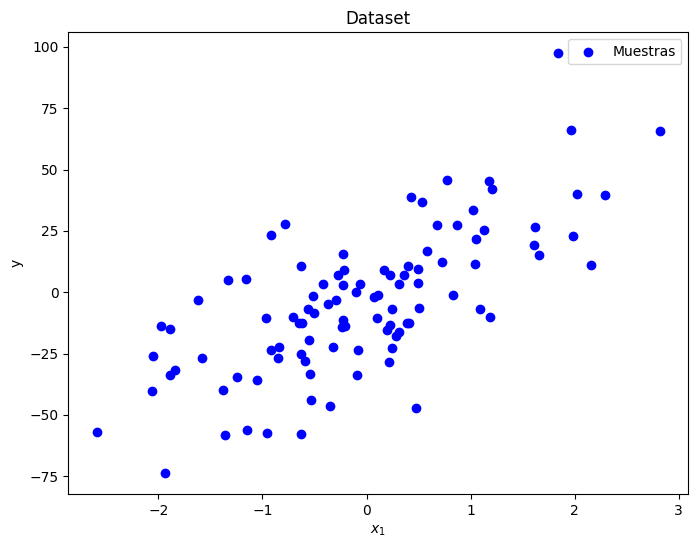

In [2]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Visualizamos

plt.figure(figsize = (8,6))

plt.scatter(X, y, color = 'blue', label = 'Muestras')

plt.xlabel('$x_1$')
plt.ylabel('y')
plt.title('Dataset')

plt.legend()
plt.show()

# **Robusta Laplace**

El método de **Laplace** en **regresión lineal robusta** se obtiene como el **estimador de maxima verosimilitud** (MLE) cuando se asume que las observaciones $y_i$ son independientes y provienen de una **distribución de laplace** con media $w^T x$ y escala constante $b$

$$p(y \mid w, \theta)$$
$$p(y \mid w, X, b) = \text{Laplace}(y \mid Xw, b)$$
$$p(y \mid w, X, b) = \prod_{i=1}^n \frac{1}{2b} e^{-\frac{|y_i - w^T x_i|}{b}}$$

**Verosimilitud**

$$p(y \mid w, X, b) = \prod_{i=1}^n \frac{1}{2b} e^{-\frac{|y_i - w^T x_i|}{b}}$$

**Log Verosimilitud**  

$$LL(y \mid w, X, b) = \log \left(\prod_{i=1}^n \frac{1}{2b} e^{-\frac{|y_i - w^T x_i|}{b}}\right)$$
$$LL(y \mid w, X, b)  = \sum_{i=1}^n \log \left(\frac{1}{2b} e^{-\frac{|y_i - w^T x_i|}{b}}\right)$$

$$LL(y \mid w, X, b)   = - n \log \left(2 b\right) - \frac{1}{b} \cdot ||y - Xw||_1$$

**Negative Log Verosimilitud** 

$$NLL(y \mid w, X, b) = n \log \left(2 b\right) + \frac{1}{b} \cdot ||y - Xw||_1$$

**Nota:** Usamos el **Negative Log Verosimilitud** ya que convertimos un problema de maximizacion en minimizacion lo cual es mas estable computacionalmente, Este metodo no tiene **Solucion Analitica**

In [3]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, weights, b, bias, norm = True): 

    n = len(y) 

    log_likehood = np.zeros_like(weights, dtype = float)

    for idx, weight in enumerate(weights): 

        residuals = y - (X * weight + bias)

        log_likehood[idx] = - n * np.log(2 * b) - ((1 / b) * np.sum(np.abs(residuals)))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood 

# Visualizamos 

w_vals = np.linspace(-10, 30, 1000)

def viz(b = 1, bias = 0, w = 0):

    log_likehood = likelihood(X, y, w_vals, b, bias) 
    
    fig, axes = plt.subplots(1, 2, figsize = (24,6))

    y_pred = w * X + bias

    axes[0].scatter(X, y, label = "Muestras", color = "black")
    axes[0].plot(X, y_pred, color = "blue", label = rf"$y = {w:0.2f}x + {bias}$" if np.sign(bias) == 1 else rf"$y = {w:0.2f}x {bias}$")
    
    for xi, yi, ypi in zip(X, y, y_pred):
        axes[0].plot([xi, xi], [yi, ypi], color = "red", linestyle = "--", alpha = 0.7)
    
    axes[0].set_title(f"Regresion Lineal")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("y")
    axes[0].legend()

    axes[1].plot(w_vals, log_likehood, label = "Likelihood", color = "green")
    axes[1].axvline(x = w, color = "blue", linestyle = "--", label = rf"$w_1$ = {w}")
    axes[1].set_title("MLE")
    axes[1].set_xlabel(r"$w_1$")
    axes[1].set_ylabel("PDF")
    axes[1].legend()

    plt.tight_layout()
    return plt.show()

interact(viz, b = FloatText(value = 1, description = 'b'), w = FloatText(value = 0, description = 'w'), bias = FloatText(value = 0, description = 'bias'))
plt.show()

interactive(children=(FloatText(value=1.0, description='b'), FloatText(value=0.0, description='bias'), FloatTe…

### **Solucion Convexa** 

Podemos calcular el parametro de **maxima verosimilitud** $w$, como un problema de **optimizacion convexa** utilizando la funcion de **Negative Log-Verosimilitud**:

$$NLL(y \mid w, X, b) = n \log \left(2 b\right) + \frac{1}{b} \cdot ||y - Xw||_1$$

Nos quedamos con los terminos que dependen de $w$

$$\text{Loss} = \frac{1}{b} \cdot ||y - Xw||_1$$
$$\text{Loss} = ||y - Xw||_1$$

Podemos resolverlo como un **problema convexo** sin restricciones 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_1
\end{align*}$$

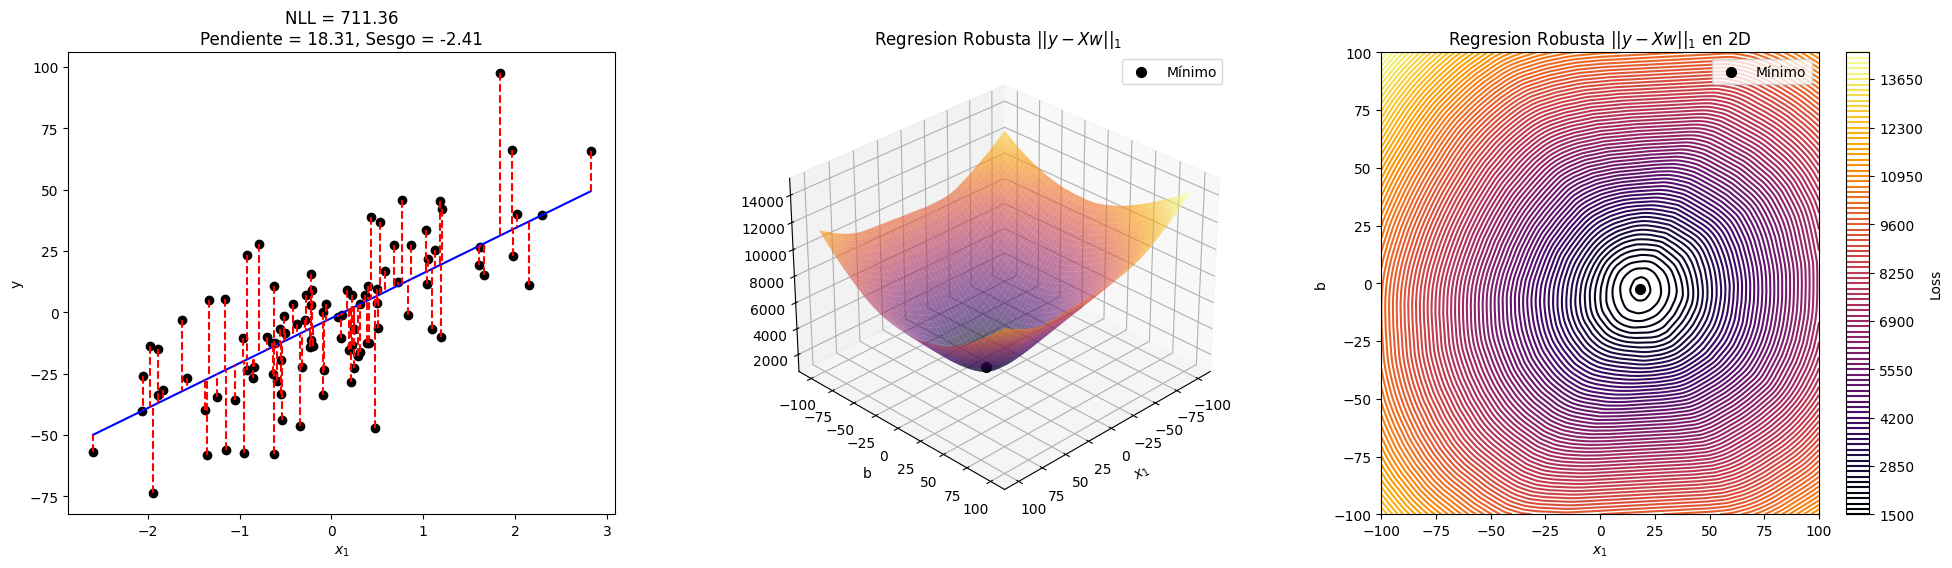

In [4]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, b = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = n * np.log(2 * b) + ((1 / b) * np.sum(np.abs(resid)))

    return nll_likelihood  

# Obtenemos el parametro de Maxima Verosimilitud

b = 3

X_with_bias = np.vstack([np.ones_like(X), X]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.norm1(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, b)  

# Visualizamos 

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection = '3d')
ax3 = fig.add_subplot(1, 3, 3)

x_line = np.linspace(X.min(), X.max(), 100)
y_line = w_opt[1]*x_line + w_opt[0]

ax1.scatter(X, y, color = 'black', label = 'Muestras')
ax1.plot(x_line, y_line, color = 'blue', label = 'Recta')

for xi, yi in zip(X, y):
    y_pred = w_opt[1] * xi + w_opt[0]
    ax1.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')    
    
ax1.set_title(f'NLL = {nll :.2f}\nPendiente = {w_opt[1] :.2f}, Sesgo = {w_opt[0] :.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('y')

m_vals = np.linspace(-100, 100, 500)
b_vals = np.linspace(-100, 100, 500)
M, B = np.meshgrid(m_vals, b_vals)

loss = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):

        y_pred_tmp = M[i, j] * X + B[i, j]
        loss[i, j] = np.linalg.norm(y - y_pred_tmp, ord = 1)

ax2.plot_surface(M, B, loss, cmap = 'inferno', alpha = 0.6)
ax2.scatter(m_opt, b_opt, np.linalg.norm((y - (m_opt * X + b_opt)), ord = 1), color = 'black', s = 50, label = 'Mínimo')

ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'b')
ax2.set_title(r'Regresion Robusta $||y - Xw||_1$')
ax2.view_init(elev = 30, azim = 45)
ax2.legend()

contours = ax3.contour(M, B, loss, levels = 100, cmap = 'inferno')

cbar = fig.colorbar(contours, ax = ax3)
cbar.set_label('Loss')

ax3.scatter(m_opt, b_opt, color = 'black', s = 50, label = 'Mínimo')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'b')
ax3.set_title(r'Regresion Robusta $||y - Xw||_1$ en 2D')
ax3.legend()

plt.show()

# **3D**

### **Dataset**

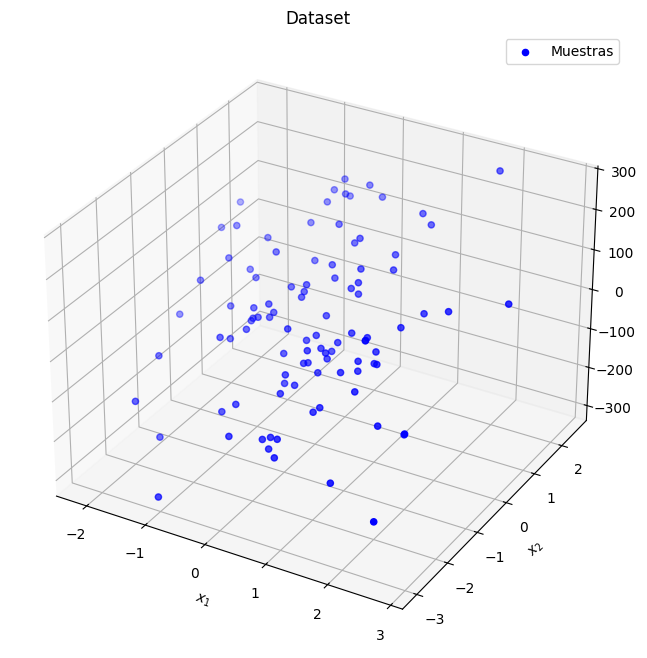

In [5]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Visualizamos

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], y, c = 'blue', marker = 'o', label = 'Muestras')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Dataset')

plt.legend()
plt.show()

In [6]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples=100, n_features=2, noise=20.0, random_state=25)

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, W1, W2, b, bias, norm = True):

    n = len(y)

    log_likehood = np.zeros_like(W1, dtype = float)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):

            weight = np.array([W1[i,j], W2[i,j]]).reshape(-1)

            residuals = y - (X @ weight + bias)

            log_likehood[i, j] = - n * np.log(2 * b) - ((1 / b) * np.sum(np.abs(residuals)))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood

# Visualizamos 

w1_vals = np.linspace(-20, 200, 200)
w2_vals = np.linspace(-20, 125, 500)

W1, W2 = np.meshgrid(w1_vals, w2_vals)

def viz(w1 = 0, w2 = 0, b = 1, bias = 0):

    log_likehood = likelihood(X, y, W1, W2, b, bias, norm = True)
   
    fig = plt.figure(figsize = (18,6))
    
    ax0 = fig.add_subplot(1, 2, 1)
    cs0 = ax0.contourf(W1, W2, log_likehood, levels = 100, cmap = 'viridis')
    ax0.set_title("Likelihood")
    ax0.set_xlabel(r"$w_1$")
    ax0.set_ylabel(r"$w_2$")
    ax0.set_xlim(0, 10)
    ax0.set_ylim(95, 100)
    fig.colorbar(cs0, ax = ax0)

    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
    x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

    X1, X2 = np.meshgrid(x1_line, x2_line)

    Y_plane = bias + w1*X1 + w2*X2

    ax3.scatter(X[:,0], X[:,1], y, color = 'black', s = 20, label = "Muestras")
    ax3.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = 'red')
    ax3.set_xlabel(r'$x_1$')
    ax3.set_ylabel(r'$x_2$')
    
    plt.tight_layout()
    plt.show()

interact(viz, w1 = FloatText(value = 0, description = r'w1'), w2 = FloatText(value = 0, description = r'w2'), b = FloatText(value = 1, description = r'b'), 
        bias = FloatText(value = 0, description = r'bias'))
plt.show()

interactive(children=(FloatText(value=0.0, description='w1'), FloatText(value=0.0, description='w2'), FloatTex…

### **Solucion Convexa**

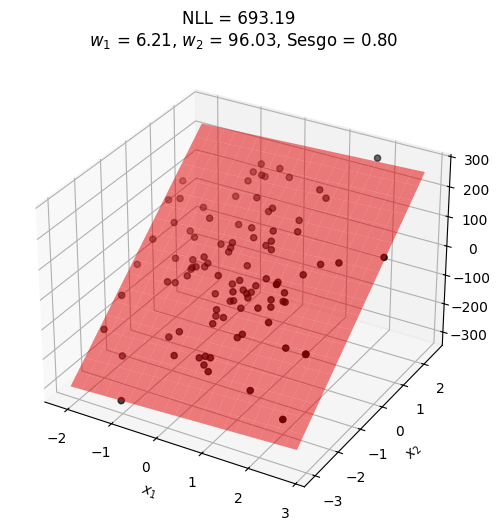

In [7]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, b = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = n * np.log(2 * b) + np.sum(np.abs(resid)) / (b) 

    return nll_likelihood  

# Obtenemos el parametro de Maxima Verosimilitud

b = 3

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

weights = cp.Variable(3)
objective = cp.Minimize(cp.norm1(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, b)  

# Visualizamos 

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

X1, X2 = np.meshgrid(x1_line, x2_line)

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 1, 1, projection = '3d')

Y_plane = b_opt + w_opt[1]*X1 + w_opt[2]*X2

ax1.scatter(X[:,0], X[:,1], y, color = "black", s = 20, label = "Muestras")
ax1.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = "red") 
    
ax1.set_title(f'NLL = {nll:.2f} \n $w_1$ = {w_opt[1]:.2f}, $w_2$ = {w_opt[2]:.2f}, Sesgo = {b_opt:.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

plt.show()